## MNIST with torchvision and skorch

## Example with Pytorch

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets,transforms 
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler

In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
DEVICE

device(type='cpu')

In [4]:
train_dataset = torchvision.datasets.MNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.MNIST('classifier_data', train=False, download=True)

Extracting classifier_data/MNIST/raw/train-images-idx3-ubyte.gz to classifier_data/MNIST/raw


Extracting classifier_data/MNIST/raw/train-labels-idx1-ubyte.gz to classifier_data/MNIST/raw


Extracting classifier_data/MNIST/raw/t10k-images-idx3-ubyte.gz to classifier_data/MNIST/raw


Extracting classifier_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to classifier_data/MNIST/raw
Processing...
Done!


/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729141890/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
import random

fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [13]:
transform = transforms.Compose([
    torchvision.transforms.ToTensor()
])
# Set the train transform
train_dataset.transform = transform
# Set the test transform
test_dataset.transform = transform

In [ ]:
m=len(train_dataset)
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64,shuffle=True)

In [ ]:
class ConvNet(nn.Module):
    def __init__(self,dropout_rate=0.4,dropout_rate2=0.2,l1=50):
        # We optimize dropout rate in a convolutional neural network.
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.drop1=nn.Dropout2d(p=dropout_rate)   

        self.fc1 = nn.Linear(32 * 7 * 7, l1)
        self.drop2=nn.Dropout2d(p=dropout_rate2)

        self.fc2 = nn.Linear(l1, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x),kernel_size = 2))

        x = F.relu(F.max_pool2d(self.conv2(x),kernel_size = 2))
        x = self.drop1(x)

        x = x.view(x.size(0),-1)

        x = F.relu(self.fc1(x))
        x = self.drop2(x)

        x = self.fc2(x)

        return x

In [ ]:
model = ConvNet()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion= nn.CrossEntropyLoss()

In [ ]:
valid_loss_min = np.Inf
train_loss_history=[]
val_loss_history=[]
train_acc_history=[]
val_acc_history=[]

num_epochs=10
#dataset_sizes = {'train':len(train_dataset),'val':len(val_dataset),'test':len(test_dataset)}

for epoch in range(num_epochs):
    
    train_loss = 0.0
    train_correct = 0
    
    
    # Training
    model.train()
    for idx, (images, labels) in enumerate(train_loader):
        
        images,labels=images.to(DEVICE),labels.to(DEVICE)
        optimizer.zero_grad() 
        output = model(images).to(DEVICE)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()
    
    valid_loss=0.0
    val_correct = 0
    #Validate Model
    model.eval()
    for idx, (images, labels) in enumerate(valid_loader):
        
        images,labels=images.to(DEVICE),labels.to(DEVICE)
        output = model(images).to(DEVICE)
        loss = criterion(output, labels)
        valid_loss += loss.item()*images.size(0)
        scores, predictions = torch.max(output.data, 1)
        val_correct += (predictions == labels).sum().item()
    
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    acc = train_correct/len(train_loader.sampler) * 100
    val_acc = val_correct/len(valid_loader.sampler) * 100
    
    train_loss_history.append(train_loss)
    val_loss_history.append(valid_loss)
    train_acc_history.append(acc)
    val_acc_history.append(val_acc)
    
    print("Epoch:{}/{} \t TL:{:.4f} \t VL:{:.4f} \t TA:{:.2f} %  \t  VA:{:.2f} %".format(epoch+1,num_epochs, 
                                                      train_loss,
                                                      valid_loss,
                                                      acc,
                                                      val_acc))
    
    # Save the best possible model
    if valid_loss < valid_loss_min:
        print("Saving Model")
        torch.save(model.state_dict(), 'MNIST_Weights.pt')
        valid_loss_min = valid_loss

## Skorch

In [5]:
pip install skorch

     |████████████████████████████████| 125 kB 1.3 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [6]:
from skorch import NeuralNetClassifier

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets,transforms 

from skorch import NeuralNetClassifier

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
class ConvNet(nn.Module):
    def __init__(self,dropout_rate=0.4,dropout_rate2=0.2,l1=50):
        # We optimize dropout rate in a convolutional neural network.
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.drop1=nn.Dropout2d(p=dropout_rate)  
        
        self.fc1 = nn.Linear(32 * 7 * 7, l1)
        self.drop2=nn.Dropout2d(p=dropout_rate2)
        
        self.fc2 = nn.Linear(l1, 10)

    def forward(self, x):
        
        x = F.relu(F.max_pool2d(self.conv1(x),kernel_size = 2))
        
        x = F.relu(F.max_pool2d(self.conv2(x),kernel_size = 2))
        x = self.drop1(x)
        
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        
        x = self.drop2(x)
        x = self.fc2(x)
        return x

In [14]:
y_train = train_dataset.targets.numpy()

In [11]:
torch.manual_seed(0)

net = NeuralNetClassifier(
    ConvNet,
    lr=1e-3,
    batch_size=64,
    optimizer=optim.Adam,
    max_epochs=10,
    criterion=nn.CrossEntropyLoss,
    iterator_train__num_workers=4,
    #iterator_train__shuffle=True,
    iterator_valid__num_workers=4,
    #iterator_valid__shuffle=True,
    device=DEVICE
)

In [15]:
net.fit(train_dataset, y=y_train);

Re-initializing module.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.3618       0.9678        0.1055  22.6182
      2        0.1243       0.9805        0.0669  22.0972
      3        0.0933       0.9818        0.0604  22.2704
      4        0.0788       0.9848        0.0535  22.4074
      5        0.0694       0.9856        0.0502  22.2957
      6        0.0611       0.9872        0.0478  22.7343
      7        0.0536       0.9875        0.0484  21.7176
      8        0.0499       0.9878        0.0435  22.1000
      9        0.0456       0.9881        0.0463  22.7754
     10        0.0439       0.9878        0.0468  21.7470


## Prediction

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score

In [17]:
y_pred = net.predict(test_dataset)
y_test = test_dataset.targets.numpy()

In [18]:
accuracy_score(y_test, y_pred)

0.991

In [19]:
confusion_matrix(y_test, y_pred)

array([[ 978,    0,    0,    0,    0,    0,    0,    1,    1,    0],
       [   0, 1133,    1,    1,    0,    0,    0,    0,    0,    0],
       [   3,    1, 1023,    0,    0,    0,    0,    4,    1,    0],
       [   0,    0,    2, 1000,    0,    3,    0,    1,    2,    2],
       [   0,    0,    0,    0,  972,    0,    1,    0,    0,    9],
       [   2,    0,    0,    3,    0,  886,    1,    0,    0,    0],
       [   4,    4,    0,    0,    1,    7,  941,    0,    1,    0],
       [   0,    2,    4,    0,    0,    0,    0, 1018,    1,    3],
       [   3,    0,    2,    1,    0,    2,    0,    1,  963,    2],
       [   3,    1,    1,    0,    3,    2,    0,    2,    1,  996]])

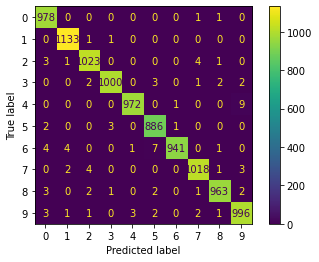

In [23]:
plot_confusion_matrix(net,test_dataset, y_test.reshape(-1, 1))
plt.show()

## K cross validation

In [ ]:
from torch.utils.data import ConcatDataset

In [ ]:
dataset = ConcatDataset([train_dataset, test_dataset])

In [ ]:
y = np.array([y for x, y in iter(dataset)])

In [ ]:
from skorch.helper import SliceDataset

mnist_sliceable = SliceDataset(dataset)

In [ ]:
torch.manual_seed(0)

net = NeuralNetClassifier(
    ConvNet,
    lr=1e-3,
    batch_size=64,
    optimizer=optim.Adam,
    max_epochs=10,
    criterion=nn.CrossEntropyLoss,
    iterator_train__num_workers=4,
    #iterator_train__shuffle=True,
    iterator_valid__num_workers=4,
    #iterator_valid__shuffle=True,
    device=DEVICE
)

In [ ]:
scores = cross_val_score(net, mnist_sliceable,y, cv = 5, scoring = "accuracy")

In [ ]:
print(scores)
print(scores.mean())